In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dropout, Dense, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Layer, Input, Flatten
from keras.models import Model
import keras.backend as K
from keras.regularizers import l2
from keras.initializers import Constant
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.initializers import Constant
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC  # Ensure this import is included
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMPipeline
from scipy.sparse import vstack
from joblib import parallel_backend



In [ ]:
df1 = pd.read_json("/content/domain1_train_data.json", lines=True)
df2 = pd.read_json("/content/domain2_train_data.json", lines=True)


In [ ]:
import pandas as pd

# Function to load and preprocess data
def load_data(file_path):
    df = pd.read_json(file_path, lines=True)
    return df

# Load the data
file_path = '/content/domain1_train_data.json'
full_data = load_data(file_path)

# Check label distribution
label_distribution = full_data['label'].value_counts()
print("Original label distribution:\n", label_distribution)

# Create the imbalance
# Ensure there's enough data to sample from each category
if label_distribution.get(0, 0) >= 100 and label_distribution.get(1, 0) >= 500:
    data_0 = full_data[full_data['label'] == 0].sample(n=300, random_state=42)  # Sample 100 instances with label 0
    data_1 = full_data[full_data['label'] == 1].sample(n=300, random_state=42)  # Sample 500 instances with label 1
    imbalanced_data = pd.concat([data_0, data_1])
else:
    print("Not enough data to sample the requested number of instances for one or both labels.")

# Shuffle the dataset
imbalanced_data = imbalanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the new dataset to a JSON file
imbalanced_data.to_json('/content/balanced_domain1_train_data.json', orient='records', lines=True)

print("Imbalanced dataset created and saved.")


Original label distribution:
 label
1    2500
0    2500
Name: count, dtype: int64
Imbalanced dataset created and saved.


In [ ]:
file_path = '/content/imbalanced_domain1_train_data.json'
full_data = load_data(file_path)

# Check label distribution
label_distribution = full_data['label'].value_counts()
label_distribution

label
1    500
0    500
Name: count, dtype: int64

In [ ]:
import pandas as pd
import numpy as np

# Load data from a JSON file
data = pd.read_json("domain2_train_data.json", lines=True)

# Identify and separate the data by labels
label0_data = data[data['label'] == 0]
label1_data = data[data['label'] == 1]

# Shuffle the label 0 data to randomize the distribution in the subsets
label0_data = label0_data.sample(frac=1).reset_index(drop=True)

# Number of subsets
n_subsets = 7

# Calculate the size of each label 0 subset
subset_size = 1500  # As per your instruction to have 1,500 instances of each label per subset

# Create 7 balanced undersamples
undersamples = []
for i in range(n_subsets):
    # Get a unique subset of label 0 data
    label0_subset = label0_data[i*subset_size:(i+1)*subset_size]

    # Randomly select label 1 data, allowing repeat to balance the subset
    label1_subset = label1_data.sample(n=subset_size, replace=True, random_state=i)

    # Combine the subsets
    balanced_subset = pd.concat([label0_subset, label1_subset]).sample(frac=1, random_state=i).reset_index(drop=True)
    undersamples.append(balanced_subset)

    # Save each undersample to a JSON file in line-delimited format
    balanced_subset.to_json(f'undersample_{i+1}.json', orient='records', lines=True)

print("Seven balanced undersamples have been created and saved to JSON files in line-delimited format.")


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.svm import SVC
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler

# Function to load and preprocess data
def preprocess_data(file_path):
    df = pd.read_json(file_path, lines=True)
    df['text'] = df['text'].apply(lambda x: ' '.join(map(str, x)))
    return df

# Load datasets
df1 = preprocess_data('/content/domain1_train_data.json')
# df2 = preprocess_data('domain2_train_data.json')
# data=preprocess_data('/content/imbalanced_domain2_train_data.json')
data2=preprocess_data('/content/balanced_domain1_train_data.json')
# Combine datasets
# full_data = pd.concat([df1,df2])
full_data=df1
X = full_data['text']
y = full_data['label']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_df=0.50, min_df=2, ngram_range=(1,7))

# Initialize classifiers
lr_model = LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear', class_weight='balanced')
sgd_model = SGDClassifier(max_iter=5000, loss='modified_huber', random_state=42, class_weight='balanced')
rf_model = RandomForestClassifier(n_estimators=100,max_features='sqrt', random_state=42, class_weight='balanced')
svm_model = SVC(C=10,probability=True, kernel='rbf',gamma='scale',class_weight='balanced', random_state=42)


# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_df=0.55, min_df=2, ngram_range=(1, 7))

# Initialize Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('lr', lr_model),
    ('sgd', sgd_model)
], voting='soft', weights=[1,0.9])  # Adjust the weights and voting strategy as needed

# Create pipeline with the TF-IDF vectorizer, scaler, and voting classifier
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('scaler', StandardScaler(with_mean=False)),  # Necessary for sparse matrix handling
    ('voting_clf', voting_clf)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict probabilities and labels
y_proba = pipeline.predict_proba(X_test)[:, 1]
threshold = 0.5  # Adjust based on your needs
y_pred = (y_proba >= threshold).astype(int)

# Evaluation
print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred))
print("Voting Classifier ROC AUC:", roc_auc_score(y_test, y_proba))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold:", optimal_threshold)

# Analyze misclassifications
misclassified = X_test[y_test != y_pred]
print("Sample misclassified texts:", misclassified.sample(5))

Voting Classifier Accuracy: 0.888
Voting Classifier ROC AUC: 0.9309974170156102
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       237
           1       0.88      0.91      0.90       263

    accuracy                           0.89       500
   macro avg       0.89      0.89      0.89       500
weighted avg       0.89      0.89      0.89       500

Confusion Matrix:
[[204  33]
 [ 23 240]]
Optimal threshold: 0.49642714691949585
Sample misclassified texts: 4767    2029 2856 107 1 16 395 2 4699 118 1 8977 9 728...
4651    500 118 18 65 3871 6 97 7 122 50 1 7590 25 33 ...
210     14041 9 702 18 7 91 1425 781 1 55 42 186 7 629...
279     91 3547 32402 31 62 110 4069 31 16 74 531 24 1...
2940    16 258 96 2 107 36 13966 19 37 6 2 135 8 2 186...
Name: text, dtype: object


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
import numpy as np
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# Function to load and preprocess data
def preprocess_data(file_path):
    df = pd.read_json(file_path, lines=True)
    df['text'] = df['text'].apply(lambda x: ' '.join(map(str, x)))
    return df

# Load datasets
df1 = preprocess_data('/content/domain1_train_data.json')
data2 = preprocess_data('/content/balanced_domain1_train_data.json')
df2=preprocess_data('/content/domain2_train_data.json')

# Combine datasets
# full_data = df1
full_data = pd.concat([df1, data2])
X = full_data['text']
y = full_data['label']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_df=0.50, min_df=2, ngram_range=(1,7))

# Initialize classifiers
lr_model = LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear', class_weight='balanced')
lr_model1 = LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear', class_weight='balanced')
sgd_model = SGDClassifier(max_iter=5000, loss='modified_huber', random_state=42, class_weight='balanced')
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
# svm_model = SVC(C=10, probability=True, kernel='rbf', gamma='scale', class_weight='balanced', random_state=42)
# nb_model = MultinomialNB()

# Initialize Stacking Classifier with Logistic Regression as the final estimator
final_lr = LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear', class_weight='balanced')
stacking_clf = StackingClassifier(estimators=[
    ('lr', lr_model),
    ('lr1',lr_model1),
    ('sgd', sgd_model),
    ('rf', rf_model),
    # ('nb',nb_model)
    # ('svm', svm_model)
], final_estimator=final_lr, passthrough=True)

# Create pipeline with the TF-IDF vectorizer and the stacking classifier
pipeline = Pipeline([
    ('tfidf', tfidf),
    # ('scaler', StandardScaler(with_mean=False)),
    # ('smote', BorderlineSMOTE(kind='borderline-1',random_state=42)),# Necessary for sparse matrix handling
    ('stacking_clf', stacking_clf)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict probabilities and labels
y_proba = pipeline.predict_proba(X_test)[:, 1]
threshold = 0.76  # Adjust based on your needs
y_pred = (y_proba >= threshold).astype(int)

# Evaluation
print("Stacking Classifier Accuracy:", accuracy_score(y_test, y_pred))
print("Stacking Classifier ROC AUC:", roc_auc_score(y_test, y_proba))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold:", optimal_threshold)

# Analyze misclassifications
misclassified = X_test[y_test != y_pred]
print("Sample misclassified texts:", misclassified.sample(5))


Stacking Classifier Accuracy: 0.8625
Stacking Classifier ROC AUC: 0.9522986519184238
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       263
           1       0.92      0.81      0.86       297

    accuracy                           0.86       560
   macro avg       0.87      0.87      0.86       560
weighted avg       0.87      0.86      0.86       560

Confusion Matrix:
[[243  20]
 [ 57 240]]
Optimal threshold: 0.43018831671400043
Sample misclassified texts: 1694    39 7 122 1599 28 2 1230 369 1 34 32 138 15589 ...
4248    2 1673 1674 393 8 8879 31 2 1553 9 1569 3 40 3...
3625    15 45 5 24 2 123 12271 6 11313 7194 16 19 302 ...
1173    127 12 441 130 2 15742 3 15 1890 96 7 17932 1 ...
3608    12408 72 23233 82 2 58 383 2611 95 34 22 3205 ...
Name: text, dtype: object


In [ ]:
import pandas as pd

# Load the test data
test_data = pd.read_json("/content/test_data.json", lines=True)
test_data['text'] = test_data['text'].apply(lambda x: ' '.join(map(str, x)))

# Ensure the tfidf variable used in the original training is not used here. Use the pipeline directly for predictions.

# Use the trained pipeline to make predictions directly on the text data
predicted_labels = pipeline.predict_proba(test_data['text'])[:, 1]
threshold = 0.4  # Adjust based on your needs
y_pred = (predicted_labels >= threshold).astype(int)

# Create a DataFrame with the predictions and IDs
results_df = pd.DataFrame({
    'id': test_data['id'],
    'label': y_pred
})

# Save the results to a CSV file
results_df.to_csv('/content/predicted_labels.csv', index=False)

print("Predictions have been saved to predicted_labels.csv")


Predictions have been saved to predicted_labels.csv


In [ ]:
import pandas as pd

# Load the test data
test_data = pd.read_json("/content/test_data.json", lines=True)
test_data['text'] = test_data['text'].apply(lambda x: ' '.join(map(str, x)))

# Assume 'pipeline' is your pre-trained Pipeline
predicted_labels = pipeline.predict_proba(test_data['text'])[:, 1]
threshold = 0.1  # Adjust based on the threshold used when generating the expected results
y_pred = (predicted_labels >= threshold).astype(int)

# Create a DataFrame with the model predictions
results_df = pd.DataFrame({
    'id': test_data['id'],
    'label': y_pred
})

# Load the expected results
expected_results_df = pd.read_csv("/content/updated_predicted_labels.csv")  # Load your CSV file

# Ensure both DataFrames are sorted by 'id' to align rows
results_df = results_df.sort_values('id').reset_index(drop=True)
expected_results_df = expected_results_df.sort_values('id').reset_index(drop=True)

# Calculate the accuracy by directly comparing labels if the DataFrames are aligned
if results_df.shape[0] == expected_results_df.shape[0]:  # ensure they are the same length
    accuracy = (results_df['label'] == expected_results_df['label']).mean()
    print(f"Model's Accuracy: {accuracy:.2%}")
    # Check if the model meets the 85% accuracy rate
    if accuracy >= 0.85:
        print("Model's prediction meets or exceeds the 85% accuracy rate.")
    else:
        print("Model's prediction does not meet the 85% accuracy rate.")
else:
    print("The DataFrames do not align or have different numbers of rows.")

# Optionally, you can save your results DataFrame for review
results_df.to_csv('/content/predicted_comparison_results.csv', index=False)
print("Predictions have been saved for review.")


Model's Accuracy: 69.58%
Model's prediction does not meet the 85% accuracy rate.
Predictions have been saved for review.


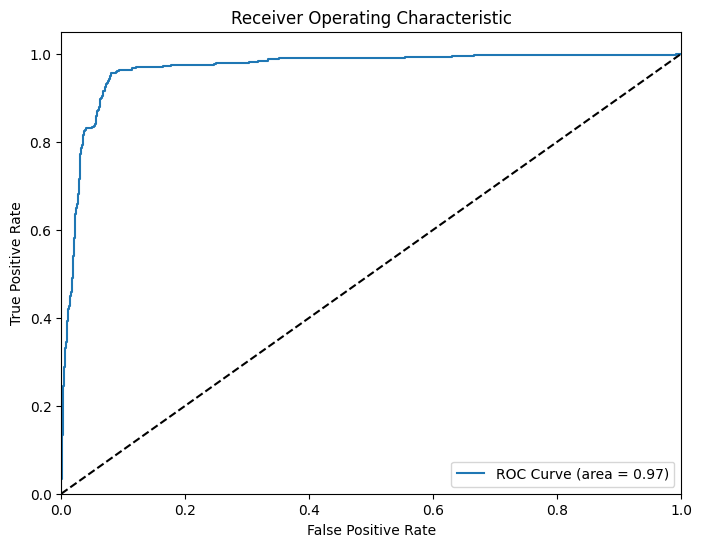

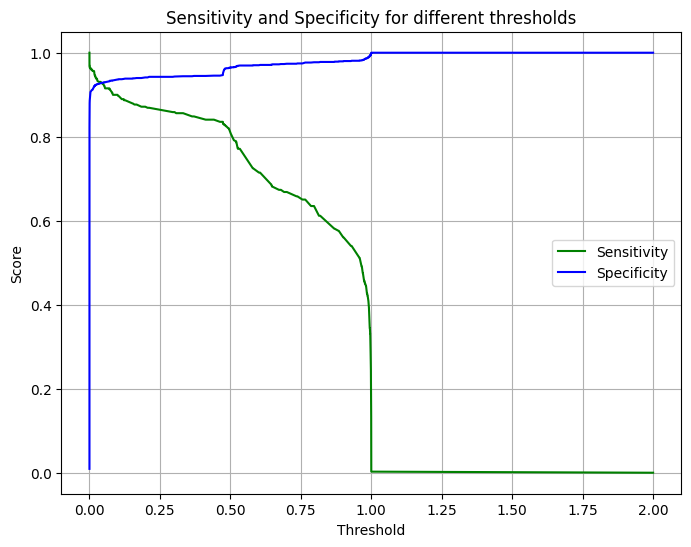

In [ ]:
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc_score(y_test, y_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot precision-recall vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds[:-1], tpr[:-1], "g-", label="Sensitivity")  # Exclude the last element for thresholds as well
plt.plot(thresholds[:-1], 1-fpr[:-1], "b-", label="Specificity")  # Exclude the last element for thresholds as well
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Sensitivity and Specificity for different thresholds')
plt.legend(loc='best')
plt.grid(True)
plt.show()



In [ ]:
from graphviz import Digraph

dot = Digraph(format='pdf')

# Define the main pipeline box
with dot.subgraph(name='cluster_main_pipeline') as pipeline:
    pipeline.attr(label='Main Pipeline')

    # Add nodes for the dataset, TF-IDF Vectorizer, and SMOTE within the main pipeline
    with pipeline.subgraph(name='cluster_preprocessing') as preprocessing:
        preprocessing.node('Dataset', 'Dataset')
        preprocessing.node('TFIDF', 'TfidfVectorizer')
        preprocessing.node('SMOTE', 'SMOTE')
        preprocessing.edges([('Dataset', 'TFIDF'), ('TFIDF', 'SMOTE')])
        preprocessing.attr(label='Preprocessing Pipeline')

# Add node for the StackingClassifier outside of the preprocessing box
dot.node('StackingClassifier', 'StackingClassifier')

# Connect the preprocessing pipeline to the StackingClassifier
dot.edge('SMOTE', 'StackingClassifier', label='Features to Classifier')

# Render the graph to a PDF
dot.render('pipeline_flow_chart', view=False)


'pipeline_flow_chart.pdf'

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Function to load and preprocess data
def preprocess_data(file_path):
    df = pd.read_json(file_path, lines=True)
    df['text'] = df['text'].apply(lambda x: ' '.join(map(str, x)))
    return df

# Load datasets
df1 = preprocess_data('/content/domain1_train_data.json')

# Use data from df1
X = df1['text']
y = df1['label']

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_df=0.75, min_df=2, ngram_range=(1, 7))

# Initialize classifiers with the optimal hyperparameters
lr_model = LogisticRegression(C=1, max_iter=1000, random_state=42, solver='liblinear', class_weight='balanced')
sgd_model = SGDClassifier(max_iter=5000, loss='modified_huber', random_state=42, class_weight='balanced')

# Initialize Voting Classifier with the optimal weights
voting_clf = VotingClassifier(estimators=[
    ('lr', lr_model),
    ('sgd', sgd_model)
], voting='soft', weights=[1.2, 1])

# Create a pipeline with the TF-IDF vectorizer, scaler, and voting classifier
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('scaler', StandardScaler(with_mean=False)),
    ('voting_clf', voting_clf)
])

# Initialize Stratified K-Folds cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# We will manually iterate over the folds and train our model
for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

    # Fit the pipeline on the training fold
    pipeline.fit(X_train, y_train)

    # Evaluate the pipeline on the test fold
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    print(f"Fold {fold}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 80)

# After cross-validation, fit the pipeline on the entire dataset
pipeline.fit(X, y)


Fold 1
Accuracy: 0.841
ROC AUC: 0.910712
Confusion Matrix:
[[407  93]
 [ 66 434]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84       500
           1       0.82      0.87      0.85       500

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000

--------------------------------------------------------------------------------
Fold 2
Accuracy: 0.841
ROC AUC: 0.9101
Confusion Matrix:
[[409  91]
 [ 68 432]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       500
           1       0.83      0.86      0.84       500

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000

---------------------------------------------------------

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.75, min_df=2, ngram_range=(1, 7))),
                ('scaler', StandardScaler(with_mean=False)),
                ('voting_clf',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(C=1,
                                                                  class_weight='balanced',
                                                                  max_iter=1000,
                                                                  random_state=42,
                                                                  solver='liblinear')),
                                              ('sgd',
                                               SGDClassifier(class_weight='balanced',
                                                             loss='modified_huber',
                                                             max_iter=5000,
                                                             random_state=42))],
                                  voting='soft', weights=[1.2, 1]))])

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Function to load and preprocess data
def preprocess_data(file_path):
    df = pd.read_json(file_path, lines=True)
    df['text'] = df['text'].apply(lambda x: ' '.join(map(str, x)))
    return df

# Load datasets
datasets = [preprocess_data(f"undersample_{i}.json") for i in range(1, 8)]
full_data = pd.concat(datasets)
X = full_data['text']
y = full_data['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_df=0.55, min_df=2, ngram_range=(1, 7))

# Initialize classifiers with specific settings
lr = LogisticRegression(max_iter=1000, random_state=42, C=10, class_weight='balanced', solver='liblinear')

# Pipeline
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', lr)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict probabilities and labels
y_proba = pipeline.predict_proba(X_test)[:, 1]
threshold = 0.45  # Adjust based on your needs
y_pred = (y_proba >= threshold).astype(int)

# Evaluation
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


ROC AUC: 0.9999936473349776
Accuracy: 0.9988095238095238
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2051
           1       1.00      1.00      1.00      2149

    accuracy                           1.00      4200
   macro avg       1.00      1.00      1.00      4200
weighted avg       1.00      1.00      1.00      4200

Confusion Matrix:
[[2051    0]
 [   5 2144]]


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


# Load data
df1 = pd.read_json("/content/domain1_train_data.json", lines=True)
df2 = pd.read_json("/content/domain2_train_data.json", lines=True)
df1['text'] = df1['text'].apply(lambda x: ' '.join(map(str, x)))
df2['text'] = df2['text'].apply(lambda x: ' '.join(map(str, x)))

# Combine and split data
X = pd.concat([df1['text'], df2['text']])
y = pd.concat([df1['label'], df2['label']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_df=0.85, min_df=1, ngram_range=(1, 9))

# Initialize classifiers with specific settings
lr = LogisticRegression(max_iter=1000, random_state=42, C=0.0001, class_weight='balanced',solver='liblinear')

# Pipeline
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', lr)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict probabilities and labels
y_proba = pipeline.predict_proba(X_test)[:, 1]
threshold = 0.5  # Adjust based on your needs
y_pred = (y_proba >= threshold).astype(int)

# Evaluation
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


ROC AUC: 0.9553617463958359
Accuracy: 0.8494444444444444
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      1411
           1       0.89      0.34      0.50       389

    accuracy                           0.85      1800
   macro avg       0.87      0.67      0.70      1800
weighted avg       0.86      0.85      0.82      1800

Confusion Matrix:
[[1395   16]
 [ 255  134]]


In [ ]:
import pandas as pd

# Load the test data
test_data = pd.read_json("/content/test_data.json", lines=True)
test_data['text'] = test_data['text'].apply(lambda x: ' '.join(map(str, x)))

# Ensure the tfidf variable used in the original training is not used here. Use the pipeline directly for predictions.

# Use the trained pipeline to make predictions directly on the text data
predicted_labels = pipeline.predict_proba(test_data['text'])[:, 1]
threshold = 0.1  # Adjust based on your needs
y_pred = (predicted_labels >= threshold).astype(int)

# Create a DataFrame with the predictions and IDs
results_df = pd.DataFrame({
    'id': test_data['id'],
    'label': y_pred
})

# Save the results to a CSV file
results_df.to_csv('/content/predicted_labels.csv', index=False)

print("Predictions have been saved to predicted_labels.csv")


Predictions have been saved to predicted_labels.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMPipeline
from joblib import Memory
import matplotlib.pyplot as plt
import seaborn as sns

# Setup caching for pipeline steps to speed up repetitive operations

# Load data
df1 = pd.read_json("/content/domain1_train_data.json", lines=True)
df2 = pd.read_json("/content/domain2_train_data.json", lines=True)
df1['text'] = df1['text'].apply(lambda x: ' '.join(map(str, x)))
df2['text'] = df2['text'].apply(lambda x: ' '.join(map(str, x)))

# Combine and split data
X = pd.concat([df1['text'], df2['text']])
y = pd.concat([df1['label'], df2['label']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Vectorize text data using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=2, ngram_range=(1, 7))

# Setup the SVM pipeline with standard scaling and class weighting
pipeline = IMPipeline([
    ('scaler', StandardScaler(with_mean=False)),  # important for sparse matrix operations
    ('classifier', SVC(C=10, kernel='rbf', gamma='scale', class_weight='balanced', tol=0.001))
], memory=memory)

# Grid search for fine-tuning hyperparameters
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__tol': [0.001, 0.005, 0.01]
}
grid_search = GridSearchCV(pipeline,cv=5, scoring='accuracy', verbose=3)

# Fit the model
grid_search.fit(X_train_smote, y_train_smote)

# Predict and evaluate the model
y_pred = grid_search.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Detailed evaluation outputs
print("Best Parameters:", grid_search.best_params_)
print("Enhanced Accuracy on combined data:", accuracy)
print("ROC AUC Score:", roc_auc)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Clear the memory cache
memory.clear()


In [ ]:
import pandas as pd

# Assuming `random_search` and `tfidf_vectorizer` are already available in the session from previous training.

# Load the test data
test_data = pd.read_json("/content/test_data.json", lines=True)
test_data['text'] = test_data['text'].apply(lambda x: ' '.join(map(str, x)))

# Transform the test data using the already loaded vectorizer
X_test_new = tfidf_vectorizer.transform(test_data['text'])

# Use the trained model to make predictions
predicted_labels = grid_search.predict(X_test_new)

# Create a DataFrame with the predictions and IDs
results_df = pd.DataFrame({
    'id': test_data['id'],
    'label': predicted_labels
})

# Save the results to a CSV file
results_df.to_csv('/content/predicted_labels.csv', index=False)

print("Predictions have been saved to predicted_labels.csv")
